# BIRDS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zuko
import torch
import torch.distributions as distributions
import torch.nn as nn
import torch.autograd as autograd
from tqdm import tqdm
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

from birds import infer
from birds.models import StochVolSimulator, StochVolPrior
from birds.plotting import plot_posterior

WARNING, MPI4PY not installed!


In [3]:
device = "cpu"

## Setup simulator and flow

Consider the stochastic volatility simulator

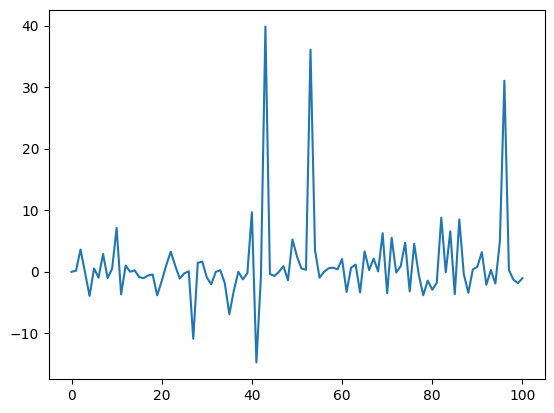

In [4]:
model = StochVolSimulator(sigma=0.0, T=100)

true_parameters = torch.tensor([-1., 3.])
obs_data = model.forward(true_parameters)

plt.plot(obs_data[0])

prior = StochVolPrior()

Also consider the MMD forecast loss:

In [5]:
y = obs_data[0]
y_matrix = y.reshape(1,-1,1)
y_sigma = torch.median(torch.pow(torch.cdist(y_matrix, y_matrix), 2))
ny = y.shape[0]
kyy = (torch.exp( - torch.pow(torch.cdist(y_matrix, y_matrix), 2) / 
                 y_sigma ) 
       - torch.eye(ny)).sum() / (ny * (ny - 1))

def mmd_loss(y, x):
    
    """
    Assumes x, y are shape (T, C)
    """
    nx = x.shape[0]
    x_matrix = x.reshape(1,-1,1)
    ## kxx
    kxx = torch.exp( - torch.pow(torch.cdist(x_matrix, x_matrix), 2) / y_sigma )
    kxx = (kxx - torch.eye(nx)).sum() / (nx * (nx - 1))
    ## kxy
    kxy = torch.exp( - torch.pow(torch.cdist(x_matrix, y_matrix), 2) / y_sigma )
    kxy = kxy.mean()
    ## Check for nans
    kxynan = torch.isnan(kxy)
    if kxynan:
        warnings.warn("kxy nan")
    kxxnan = torch.isnan(kxx)
    if kxxnan:
        warnings.warn("kxx nan")
    return kxx + kyy - 2 * kxy

Helper function for creating a new flow:

In [6]:
n_params = 2

def create_flow():

    flow = zuko.flows.MAF(n_params, 1, transforms=1, hidden_features=[50])
    flow = flow.to(device)
    print(sum(p.numel() for p in flow.parameters()))

    flow_cond = flow(torch.zeros(1))
    return flow, flow_cond

## Different gradients

Compare the score-based to pathwise-based derivatives. First, we'll look at the variance when just estimating the forecast term; then we'll look at the entire loss function, including both forecast and regularisation terms

### Just forecast terms

In the cell below, we implement the different ways to estimate the gradient:

In [7]:
def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
    pathwise_grad = 0.
    flow_cond = flow(torch.zeros((1,)))
    for n in range(N):
        theta = flow_cond.rsample(n_samples)
#         flow_lp = flow_cond.log_prob(theta)
#         prior_lp = prior.log_prob(theta)
        x = simulator(theta)
        ell = mmd_loss(_, x[0])
        assert ell.requires_grad == True
#         pathwise_loss = ell #+ flow_lp #(ell + flow_lp - prior_lp)
#         pathwise_loss.backward()
        gradient = autograd.grad(ell, [p for p in flow.parameters() if p.requires_grad])
        gradient = torch.cat([p.detach().flatten() for p in gradient])
#         gradient = torch.cat([p.grad.detach().flatten() for p in flow.parameters()])
        pathwise_grad = pathwise_grad + gradient / float(N)
    return pathwise_grad

# def get_score_based(flow, simulator, prior, n_samples=(1,), N=20):
    
#     score_based_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.sample(n_samples)
#         flow_lp = flow_cond.log_prob(theta)
# #         prior_lp = prior.log_prob(theta)
#         x = simulator(theta.detach())
#         assert x[0].requires_grad == False
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == False
#         flow_lp_grad = autograd.grad(flow_lp, [p for p in flow.parameters() if p.requires_grad])
# #         score_loss = ell * flow_lp #((ell + 1.) * flow_lp - prior_lp)
# #         score_loss.backward()
# #         gradient = torch.cat([p.grad.detach().flatten() for p in flow.parameters()])
#         gradient = ell * torch.cat([p.detach().flatten() for p in flow_lp_grad])
#         score_based_grad = score_based_grad + gradient / float(N)
#     return score_based_grad

def get_score_based(flow, simulator, prior, n_samples=(1,), N=20):
    
    score_based_grad = 0.
    flow_cond = flow(torch.zeros((1,)))
    for n in range(N):
        theta = flow_cond.sample(n_samples)
        flow_lp = flow_cond.log_prob(theta)
        x = simulator(theta.detach())
        assert x[0].requires_grad == False
        ell = mmd_loss(_, x[0])
        assert ell.requires_grad == False
        gradient = autograd.grad(ell * flow_lp, [p for p in flow.parameters() if p.requires_grad])
        gradient = torch.cat([p.detach().flatten() for p in gradient])
        score_based_grad = score_based_grad + gradient / float(N)
    return score_based_grad

def get_grads(flow, simulator, prior, n_samples=(1,), N=20, R=100, kind="pathwise"):
    
    print("Getting", kind, "gradients")
    grads = []
    for r in tqdm(range(R)):
        if kind == "pathwise":
            grads.append(get_pathwise(flow, simulator, prior, n_samples, N))
        else:
            grads.append(get_score_based(flow, simulator, prior, n_samples, N))
    return grads

First collect the score-based gradients over $R$ independent estimates of the gradient, each of which uses $N$ samples from the flow to perform Monte Carlo estimate of gradient:

In [8]:
flow, flow_cond = create_flow()
score_grads = get_grads(flow, model.forward, prior, kind="score")

404
Getting score gradients


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


This is a boxplot showing the distrbiution of the gradients estimated in each of the $R$ trials:

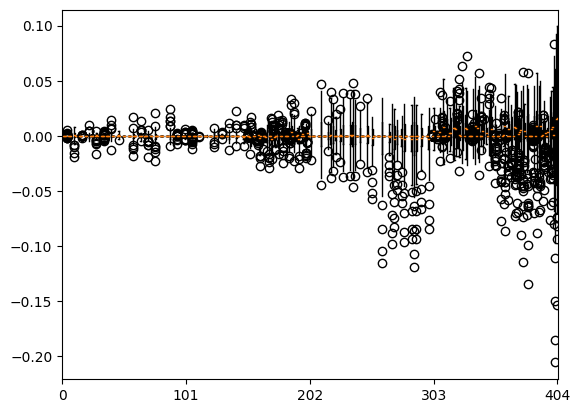

In [9]:
_ = plt.boxplot(torch.vstack(score_grads).numpy())
_ = plt.xticks([i*101 for i in range(5)], [i*101 for i in range(5)])
# plt.yscale('symlog')
ylim = plt.gca().get_ylim()

Now do the same for the pathwise derivatives:

In [10]:
pathwise_grads = get_grads(flow, model.forward, prior)

Getting pathwise gradients


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


The pathwise derivatives have much smaller variance (note that the $y$-axis scale is the same below as it was in the score-based method):

(-0.22066695503890515, 0.11442670486867428)

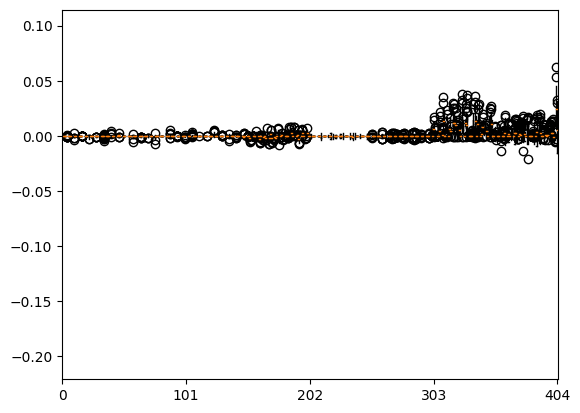

In [11]:
_ = plt.boxplot(torch.vstack(pathwise_grads).numpy())
_ = plt.xticks([i*101 for i in range(5)], [i*101 for i in range(5)])
plt.ylim(ylim)
# plt.yscale('symlog')

Both score-based and pathwise derivatives should be unbiased, so we perform a sanity check to ensure they give roughly the same expectation:

In [12]:
pathwise_means = torch.vstack(pathwise_grads).numpy().mean(axis=0)
score_means = torch.vstack(score_grads).numpy().mean(axis=0)

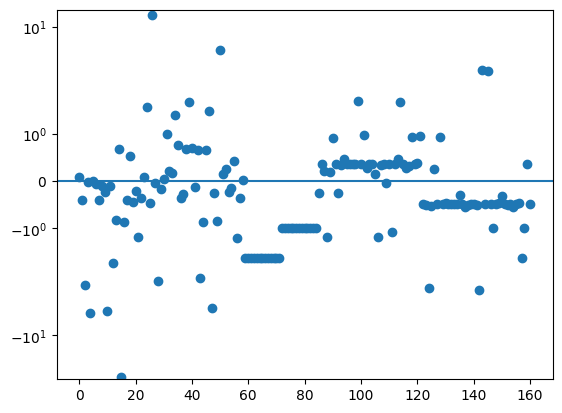

In [13]:
mask = ( ~np.isclose(pathwise_means, 0.) ) & ( ~np.isclose(score_means, 0.) )

nz_pathwise_means = pathwise_means[mask]
nz_score_means = score_means[mask]

plt.scatter(range(sum(mask)), (nz_pathwise_means - nz_score_means) / nz_score_means)
plt.axhline(0.)
plt.yscale('symlog')

Want to check numerically (rather than just by a visual inspection, as we did above) that the variance of the score-based method is higher than the pathwise based derivative. We do so by taking the standard deviation of the distribution of gradient estimates for each flow parameter for both score-based and pathwise based derivatives, then plot

\begin{equation}
    \text{pathwise derivative standard deviation }_i - \text{ score-based derivative standard deviation }_i
\end{equation}

for each flow parameter $i = 1, \ldots, \texttt{n_pars}$

In [14]:
pathwise_std = torch.vstack(pathwise_grads).numpy().std(axis=0)
score_std = torch.vstack(score_grads).numpy().std(axis=0)

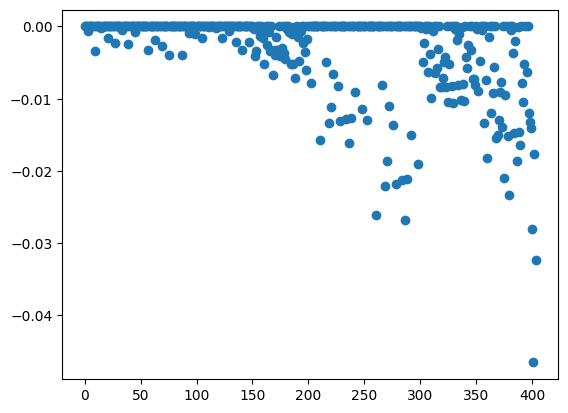

In [15]:
plt.scatter(range(pathwise_std.size), pathwise_std - score_std)
# plt.yscale('symlog')

Indeed the score-based method gives higher variance than pathwise for lots of parameters, while there are barely any parameters in the flow that result in higher variance with the pathwise derivative:

In [16]:
print("Number of flow parameters with score gradient variance greater than pathwise gradient variance:", 
      sum(score_std - pathwise_std > 0))

Number of flow parameters with score gradient variance greater than pathwise gradient variance: 161


In [17]:
print("Number of flow parameters with score gradient variance less than pathwise gradient variance:", 
      sum(score_std - pathwise_std < 0))

Number of flow parameters with score gradient variance less than pathwise gradient variance: 0


In [18]:
sum(score_std - pathwise_std == 0.)

243

### Forecast + regularisation

Now we look at the same but with both the forecast and regularisation terms. So first we adjust the gradient estimation methods:

In [19]:
def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
    """
    From algorithm 1 of Knoblauch et al (2019), https://arxiv.org/pdf/1904.02063.pdf, only in 
    this case the forecast loss is differentiable so we just differentiate through that in a pathwise manner
    """
    
    pathwise_grad = 0.
    flow_cond = flow(torch.zeros((1,)))
    for n in range(N):
        theta = flow_cond.rsample(n_samples)
        # flow loss
        flow_lp = flow_cond.log_prob(theta.detach())
        flow_lp_grad = autograd.grad(flow_lp, [p for p in flow.parameters() if p.requires_grad])
        flow_lp_grad = torch.cat([p.detach().flatten() for p in flow_lp_grad])
        # prior loss 
        prior_lp = prior.log_prob(theta)
        # simulator loss, ell
        x = simulator(theta)
        ell = mmd_loss(_, x[0])
        assert ell.requires_grad == True
        ellp_grad = autograd.grad(ell - prior_lp, [p for p in flow.parameters() if p.requires_grad])
        ellp_grad = torch.cat([p.detach().flatten() for p in ellp_grad])
        
        # Get gradient
        ### Retaining the 1. term in the first set of brackets acts to reduce variance, although it may not
        ### be the optimal baseline value -- see https://arxiv.org/pdf/1906.10652.pdf
        gradient = ellp_grad + (flow_lp.detach() - prior_lp.detach() + 1.) * flow_lp_grad
        pathwise_grad = pathwise_grad + gradient / float(N)
        
    return pathwise_grad

def get_score_based(flow, simulator, prior, n_samples=(1,), N=20):
    
    """
    From algorithm 1 of Knoblauch et al (2019), https://arxiv.org/pdf/1904.02063.pdf
    """
    
    score_based_grad = 0.
    flow_cond = flow(torch.zeros((1,)))
    for n in range(N):
        theta = flow_cond.rsample(n_samples)
        # Flow
        flow_lp = flow_cond.log_prob(theta.detach())
        flow_lp_grad = autograd.grad(flow_lp, 
                                     [p for p in flow.parameters() if p.requires_grad_])
        flow_lp_grad = torch.cat([p.detach().flatten() for p in flow_lp_grad])
        # Prior
        prior_lp = prior.log_prob(theta)
        prior_lp_grad = autograd.grad(prior_lp, [p for p in flow.parameters() if p.requires_grad])
        prior_lp_grad = torch.cat([p.detach().flatten() for p in prior_lp_grad])
        # ell
        x = simulator(theta.detach())
        assert x[0].requires_grad == False
        ell = mmd_loss(_, x[0])
        assert ell.requires_grad == False
        ### Retaining the 1. term in the first set of brackets acts to reduce variance, although it may not
        ### be the optimal baseline value -- see https://arxiv.org/pdf/1906.10652.pdf
        gradient = (ell + flow_lp.detach() - prior_lp.detach() + 1.) * flow_lp_grad - prior_lp_grad
        score_based_grad = score_based_grad + gradient / float(N)
    return score_based_grad

def get_grads(flow, simulator, prior, n_samples=(1,), N=20, R=100, kind="pathwise"):
    
    print("Getting", kind, "gradients")
    grads = []
    for r in tqdm(range(R)):
        if kind == "pathwise":
            grads.append(get_pathwise(flow, simulator, prior, n_samples, N))
        else:
            grads.append(get_score_based(flow, simulator, prior, n_samples, N))
    return grads

Collect $R$ estimates of gradient, each based on $N$ Monte Carlo samples, for score-based derivative first:

In [20]:
flow, flow_cond = create_flow()

404


In [21]:
score_grads = get_grads(flow, model.forward, prior, kind="score", N=10, R=200)

Getting score gradients


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.43it/s]


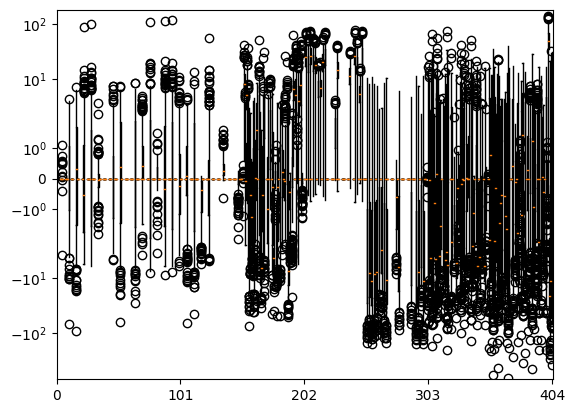

In [22]:
_ = plt.boxplot(torch.vstack(score_grads).numpy())
_ = plt.xticks([i*101 for i in range(5)], [i*101 for i in range(5)])
plt.yscale('symlog')
ylim = plt.gca().get_ylim()

Now pathwise:

In [23]:
pathwise_grads = get_grads(flow, model.forward, prior, N=10, R=200)

Getting pathwise gradients


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.40it/s]


(-691.7486351013183, 183.50685958862306)

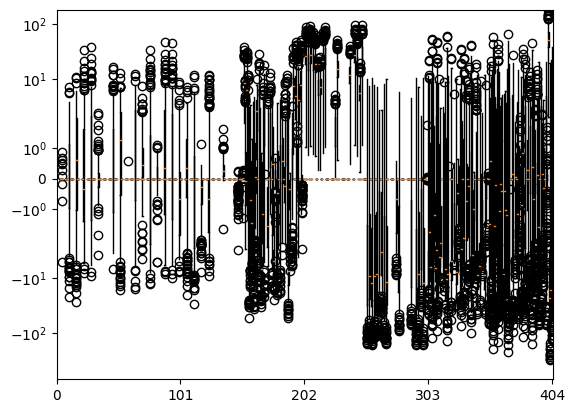

In [24]:
_ = plt.boxplot(torch.vstack(pathwise_grads).numpy())
_ = plt.xticks([i*101 for i in range(5)], [i*101 for i in range(5)])
plt.yscale('symlog')
plt.ylim(ylim)

The difference doesn't appear so dramatic now with the regularisation term.

Check again that they are both approximately giving the same expectation:

In [25]:
pathwise_means = torch.vstack(pathwise_grads).numpy().mean(axis=0)
score_means = torch.vstack(score_grads).numpy().mean(axis=0)

-60.339783


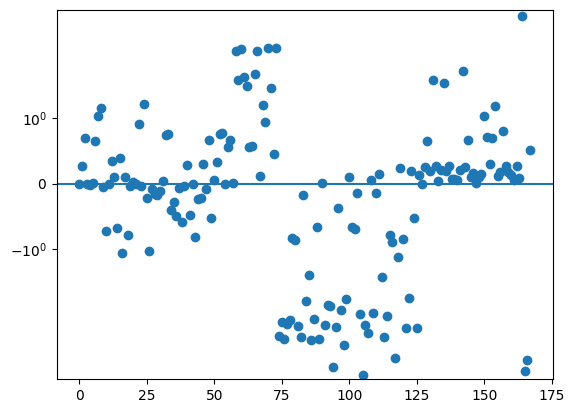

In [31]:
mask = ( ~np.isclose(pathwise_means, 0.) ) & ( ~np.isclose(score_means, 0.) )

nz_pathwise_means = pathwise_means[mask]
nz_score_means = score_means[mask]

plt.scatter(range(sum(mask)), nz_pathwise_means - nz_score_means)
plt.axhline(0.)
plt.yscale('symlog')

print(((nz_pathwise_means - nz_score_means)).sum())

Numerically compare variances:

In [27]:
pathwise_std = torch.vstack(pathwise_grads).numpy().std(axis=0)
score_std = torch.vstack(score_grads).numpy().std(axis=0)

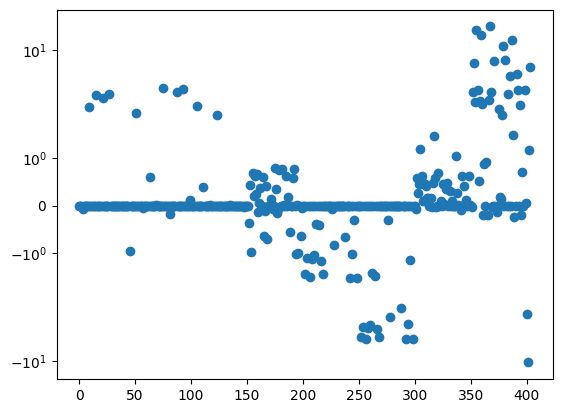

In [32]:
plt.scatter(range(pathwise_std.size), score_std - pathwise_std)
plt.yscale('symlog')

In [29]:
print("Number of parameters for which score variance larger than pathwise:", sum(score_std - pathwise_std > 0))

Number of parameters for which score variance larger than pathwise: 103


In [30]:
print("Number of parameters for which score variance is smaller than pathwise:", sum(score_std - pathwise_std < 0))

Number of parameters for which score variance is smaller than pathwise: 69


## Spare parts

I don't think any of these methods that I had originally tried for estimating gradients of the variational inference loss are correct, but I'm keeping them here for reference.

In [ ]:
# def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
#     pathwise_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # flow loss
#         flow_lp = flow_cond.log_prob(theta.detach())
#         flow_lp_grad = autograd.grad(flow_lp, [p for p in flow.parameters() if p.requires_grad])
#         flow_lp_grad = torch.cat([p.detach().flatten() for p in flow_lp_grad])
#         # prior loss 
#         prior_lp = prior.log_prob(theta)
#         # simulator loss, ell
#         x = simulator(theta)
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == True
#         ellp_grad = autograd.grad(ell - prior_lp, [p for p in flow.parameters() if p.requires_grad])
#         ellp_grad = torch.cat([p.detach().flatten() for p in ellp_grad])
        
#         # Get gradient
#         gradient = ellp_grad + flow_lp_grad
#         pathwise_grad = pathwise_grad + gradient / float(N)
        
#     return pathwise_grad

# def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
#     pathwise_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # flow loss
#         flow_lp = flow_cond.log_prob(theta.detach())
#         # prior loss 
#         prior_lp = prior.log_prob(theta)
#         # simulator loss, ell
#         x = simulator(theta)
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == True
        
#         # Get gradient
#         total_loss = ell + flow_lp - prior_lp
#         gradient = autograd.grad(total_loss, [p for p in flow.parameters() if p.requires_grad])
#         gradient = torch.cat([p.detach().flatten() for p in gradient])
#         pathwise_grad = pathwise_grad + gradient / float(N)
        
#     return pathwise_grad

# def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
#     pathwise_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # prior loss 
#         prior_lp = prior.log_prob(theta)
#         # simulator loss, ell
#         x = simulator(theta)
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == True
        
#         # Get gradient -- ignore contribution from gradient of log prob density of flow because this is exactly 0
#         total_loss = ell - prior_lp
#         gradient = autograd.grad(total_loss, [p for p in flow.parameters() if p.requires_grad])
#         gradient = torch.cat([p.detach().flatten() for p in gradient])
#         pathwise_grad = pathwise_grad + gradient / float(N)
        
#     return pathwise_grad

# def get_pathwise(flow, simulator, prior, n_samples=(1,), N=20):
    
#     total_loss = 0.
#     flow_cond = flow(torch.zeros((1,)))
    
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # flow loss
#         flow_lp = flow_cond.log_prob(theta.detach())
#         # prior loss 
#         prior_lp = prior.log_prob(theta)
#         # simulator loss, ell
#         x = simulator(theta)
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == True
        
#         # Get gradient
#         total_loss = total_loss + (ell + flow_lp - prior_lp) / float(N)
    
#     gradient = autograd.grad(total_loss, [p for p in flow.parameters() if p.requires_grad])
#     gradient = torch.cat([p.detach().flatten() for p in gradient])
        
#     return gradient

# def get_score_based(flow, simulator, prior, n_samples=(1,), N=20):
    
#     score_based_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # Flow
#         flow_lp = flow_cond.log_prob(theta.detach())
#         flow_lp_grad = autograd.grad(flow_lp, 
#                                      [p for p in flow.parameters() if p.requires_grad_])
#         flow_lp_grad = torch.cat([p.detach().flatten() for p in flow_lp_grad])
#         # Prior
#         prior_lp = prior.log_prob(theta)
#         prior_lp_grad = autograd.grad(prior_lp, [p for p in flow.parameters() if p.requires_grad])
#         prior_lp_grad = torch.cat([p.detach().flatten() for p in prior_lp_grad])
#         # ell
#         x = simulator(theta.detach())
#         assert x[0].requires_grad == False
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == False
# #         gradient = (ell + 1.) * flow_lp_grad - prior_lp_grad 
#         gradient = ell * flow_lp_grad - prior_lp_grad 
#         score_based_grad = score_based_grad + gradient / float(N)
#     return score_based_grad

# def get_score_based(flow, simulator, prior, n_samples=(1,), N=20):
    
#     score_based_grad = 0.
#     flow_cond = flow(torch.zeros((1,)))
#     for n in range(N):
#         theta = flow_cond.rsample(n_samples)
#         # Flow
#         flow_lp = flow_cond.log_prob(theta.detach())
# #         flow_lp_grad = autograd.grad(flow_lp, 
# #                                      [p for p in flow.parameters() if p.requires_grad_])
# #         flow_lp_grad = torch.cat([p.detach().flatten() for p in flow_lp_grad])
#         # Prior
#         prior_lp = prior.log_prob(theta)
# #         prior_lp_grad = autograd.grad(prior_lp, [p for p in flow.parameters() if p.requires_grad])
# #         prior_lp_grad = torch.cat([p.detach().flatten() for p in prior_lp_grad])
#         # ell
#         x = simulator(theta.detach())
#         assert x[0].requires_grad == False
#         ell = mmd_loss(_, x[0])
#         assert ell.requires_grad == False
#         ### Variance reduction is induced by adding 1. to ell
#         total_loss = ell * flow_lp - prior_lp
# #         total_loss = (ell + 1.) * flow_lp - prior_lp
#         gradient = autograd.grad(total_loss, [p for p in flow.parameters()])
#         gradient = torch.cat([p.detach().flatten() for p in gradient])
#         score_based_grad = score_based_grad + gradient / float(N)
#     return score_based_grad